# Testing on caltech101 Dataset

**Importing the libraries and loading the dataset**

In [1]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from Classifier import Classifier
from Classifier import Classifier
import os
import openai
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['openai']['api_key']
openai.api_key = api_key

# Load the dataset using ImageFolder
dataset = ImageFolder(root='./caltech-101', transform=transforms.ToTensor())
labels=dataset.classes

Label: Motorbikes


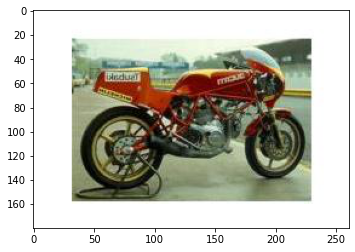

In [2]:
plt.imshow(dataset[2050][0].permute(1,2,0))
print(f"Label: {labels[dataset[2050][1]]}")

In [3]:
caltech=Classifier(labels)

In [4]:
caltech.load_classifier('caltech.txt')

In [5]:
caltech.descriptors['Motorbikes']

['has handlebars',
 'has a seat',
 'has two wheels',
 'is typically brightly colored']

In [6]:
correct=0
total=len(dataset)
for (img,label) in dataset:
    caltech.

8999

In [8]:
dataset[0]

(tensor([[[0.6157, 0.6392, 0.6745,  ..., 0.6902, 0.6941, 0.6941],
          [0.6471, 0.6667, 0.6941,  ..., 0.7098, 0.7294, 0.6824],
          [0.6941, 0.7098, 0.7333,  ..., 0.7255, 0.6667, 0.6745],
          ...,
          [0.7412, 0.8706, 0.9647,  ..., 0.9725, 0.9216, 0.6588],
          [0.8980, 0.9922, 0.9804,  ..., 0.9216, 0.8431, 0.6549],
          [0.6980, 0.7569, 0.6824,  ..., 0.8353, 0.7412, 0.6588]],
 
         [[0.1294, 0.1294, 0.1294,  ..., 0.1137, 0.1059, 0.0980],
          [0.1412, 0.1333, 0.1373,  ..., 0.1647, 0.1725, 0.0980],
          [0.1529, 0.1490, 0.1490,  ..., 0.2157, 0.1608, 0.1176],
          ...,
          [0.2000, 0.3529, 0.4863,  ..., 0.5059, 0.4627, 0.1059],
          [0.3725, 0.4941, 0.5255,  ..., 0.4196, 0.3490, 0.0980],
          [0.1804, 0.2627, 0.2431,  ..., 0.3137, 0.2196, 0.0941]],
 
         [[0.0000, 0.0431, 0.1020,  ..., 0.0824, 0.1020, 0.0157],
          [0.0000, 0.0314, 0.0824,  ..., 0.0510, 0.0863, 0.0118],
          [0.0000, 0.0157, 0.0627,  ...,